# DESI mini end-to-end test

Test end-to-end dataflow using a small number of tiles.<br/>
October 2017

## Basic setup to run this yourself at NERSC ##

On cori.nersc.gov, clone two_percent_DESI:
```
git clone https://github.com/desihub/two_percent_DESI
```
At the time of this writing, this notebook is still in the "minitest" branch so switch to that:
```
cd two_percent_DESI
git checkout minitest
```
This notebook and its configuration files are in `two_percent_DESI/mini`.

Configure the desi-17.9 jupyter notebook kernel for your account following the instructions at
https://desi.lbl.gov/trac/wiki/Computing/JupyterAtNERSC.  Then go to https://jupyter-dev.nersc.gov,
navigate to where you checked out `two_percent_DESI/mini` and start your own copy of this notebook.

To get the same version of code with an interactive login:
```console
source /project/projectdirs/desi/software/desi_environment.sh 17.9
```
(or `desi_environment.csh` for t/csh users)

### Notebook + Interactive Batch Jobs ###

Many steps are run directly in this notebook.  Some steps are slow enough that they benefit from using all the cores on 10-15 nodes.  In these cases, the notebook prints the commands for you to run from within an interactive batch session at NERSC.  The intension is that all steps can be run within an hour or so, but it isn't as simple as just Cell -> Run All.

In [1]:
import os, sys, glob
import numpy as np
import healpy as hp
from astropy.table import Table
import fitsio
import desimodel.io
import desimodel.footprint
import subprocess
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Set some environment variables and create output directories

The next cell will create directories under `$SCRATCH/desi/dev/end2end/` and set environment variables for this mapping:

| Directory             | NB variable   | Environment Variable                              |
|-----------------------|---------------|---------------------------------------------------|
| survey/               | surveydir     | \$DESISURVEY_OUTPUT                               |
| targets/              | targetdir     |                                                   |
| fiberassign/          | fibassigndir  |                                                   |
| spectro/redux/mini/   | reduxdir      | \$DESI_SPECTRO_REDUX/\$SPECPROD                   |
| spectro/sim/mini/     | simdatadir    | \$DESI_SPECTRO_DATA = \$DESI_SPECTRO_SIM/$PIXPROD |

It additionally derives the location of this `two_percent_DESI/mini/` directory as the notebook
variable `minitestdir` for use in later cells.


In [3]:
basedir = os.path.join(os.environ['SCRATCH'], 'desi', 'dev', 'end2end')
surveydir = os.environ['DESISURVEY_OUTPUT'] = os.path.join(basedir, 'survey')
targetdir = os.path.join(basedir, 'targets')
fibassigndir = os.path.join(basedir, 'fiberassign')
minitestdir = os.getcwd()

os.environ['DESI_SPECTRO_REDUX'] = os.path.join(basedir, 'spectro', 'redux')
os.environ['DESI_SPECTRO_SIM'] = os.path.join(basedir, 'spectro', 'sim')
os.environ['PIXPROD'] = 'mini'
os.environ['SPECPROD'] = 'mini'

reduxdir = os.path.join(os.environ['DESI_SPECTRO_REDUX'], os.environ['SPECPROD'])
simdatadir = os.path.join(os.environ['DESI_SPECTRO_SIM'], os.environ['PIXPROD'])
os.environ['DESI_SPECTRO_DATA'] = simdatadir

os.makedirs(surveydir, exist_ok=True)
os.makedirs(targetdir, exist_ok=True)
os.makedirs(fibassigndir, exist_ok=True)
os.makedirs(reduxdir, exist_ok=True)
os.makedirs(simdatadir, exist_ok=True)

if 'csh' in os.environ['SHELL']:
    envcmd = """\
source /project/projectdirs/desi/software/desi_environment.csh 17.9
set basedir = ${SCRATCH}/desi/dev/end2end
setenv DESISURVEY_OUTPUT ${basedir}/survey
setenv DESI_SPECTRO_REDUX ${basedir}/spectro/redux
setenv DESI_SPECTRO_SIM ${basedir}/spectro/sim
setenv SPECPROD mini
setenv PIXPROD mini
setenv DESI_SPECTRO_DATA ${DESI_SPECTRO_SIM}/${PIXPROD}
"""
else:
    envcmd = """\
source /project/projectdirs/desi/software/desi_environment.sh 17.9
basedir=${SCRATCH}/desi/dev/end2end
export DESISURVEY_OUTPUT=${basedir}/survey
export DESI_SPECTRO_REDUX=${basedir}/spectro/redux
export DESI_SPECTRO_SIM=${basedir}/spectro/sim
export SPECPROD=mini
export PIXPROD=mini
export DESI_SPECTRO_DATA=${DESI_SPECTRO_SIM}/${PIXPROD}
"""
print('To recreate this environment from a login terminal:\n')
print(envcmd)

To recreate this environment from a login terminal:

source /project/projectdirs/desi/software/desi_environment.sh 17.9
basedir=${SCRATCH}/desi/dev/end2end
export DESISURVEY_OUTPUT=${basedir}/survey
export DESI_SPECTRO_REDUX=${basedir}/spectro/redux
export DESI_SPECTRO_SIM=${basedir}/spectro/sim
export SPECPROD=mini
export PIXPROD=mini
export DESI_SPECTRO_DATA=${DESI_SPECTRO_SIM}/${PIXPROD}



## Run survey simulations on a subset of tiles

This will select a test subset of tiles in the NGC and run survey simulations for observations during March 2020.  These steps should take <5 minutes to run.

In [66]:
#- Make a subset of tiles to use
alltiles = Table(desimodel.io.load_tiles())
ii = (150 < alltiles['RA']) & (alltiles['RA']<152) & (30<alltiles['DEC']) & (alltiles['DEC']<35)
tiles = Table(alltiles[ii])

#- Write two copies:
#- one in two_percent_DESI/mini because that is where the surveysim config file will look, and
#- one in $targetdir/ for later use by mpi_select_mock_targets
tiles.write('test-tiles.fits', overwrite=True)
tilefile = os.path.join(targetdir, 'test-tiles.fits')
tiles.write(tilefile, overwrite=True)

#- Show what tiles are in the subset
Table(tiles)

TILEID,RA,DEC,PASS,IN_DESI,EBV_MED,AIRMASS,STAR_DENSITY,EXPOSEFAC,PROGRAM,OBSCONDITIONS
int32,float64,float64,int16,int16,float32,float32,float32,float32,str6,int32
1165,150.69,33.86,0,1,0.0126537,1.02517,1416.73,1.11412,DARK,1
6927,151.78,33.84,1,1,0.0134791,1.02517,1402.3,1.11972,DARK,1
11108,150.87,31.23,1,1,0.0189035,1.02543,1451.67,1.15767,DARK,1
16870,151.96,31.21,2,1,0.0207586,1.02544,1403.42,1.17082,DARK,1
18465,150.47,33.2,3,1,0.0133246,1.02504,1433.89,1.11849,DARK,1
24227,151.56,33.18,4,1,0.0146741,1.02503,1410.88,1.12771,GRAY,2
28408,150.73,30.52,4,1,0.0196785,1.02587,1478.4,1.16376,GRAY,2
34170,151.82,30.5,5,1,0.0216828,1.02589,1414.49,1.17806,BRIGHT,4
39942,150.31,32.41,6,1,0.0144966,1.02505,1466.71,1.12651,BRIGHT,4


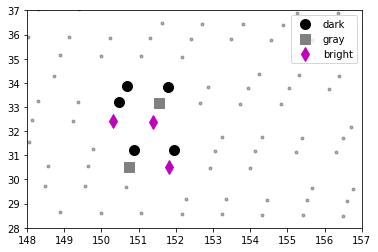

In [67]:
#- Plot those tiles
clf()
plot(alltiles['RA'], alltiles['DEC'], 'k.', alpha=0.3, label='_none_')
isdark = tiles['PROGRAM'] == 'DARK'
isgray = tiles['PROGRAM'] == 'GRAY'
isbright = tiles['PROGRAM'] == 'BRIGHT'
plot(tiles['RA'][isdark], tiles['DEC'][isdark], 'o', color='k', ms=10, label='dark')
plot(tiles['RA'][isgray], tiles['DEC'][isgray], 's', color='0.5', ms=10, label='gray')
plot(tiles['RA'][isbright], tiles['DEC'][isbright], 'd', color='m', ms=10, label='bright')
xlim(148, 157); ylim(28, 37)
legend()

In [22]:
!time surveyinit --config-file ./desisurvey-config.yaml


real	0m9.828s
user	0m9.226s
sys	0m0.500s


In [23]:
#- Use 0d fiber assignment delay to move on with mini sim quickly
!time surveyplan --config-file ./desisurvey-config.yaml --rules rules-layers.yaml --create --fa-delay 0d


real	0m2.173s
user	0m1.627s
sys	0m0.537s


In [24]:
!time surveysim --config-file ./desisurvey-config.yaml --seed 123 >> $surveydir/survey.log


real	0m16.042s
user	0m15.231s
sys	0m0.448s


In [25]:
import subprocess
import time
plan_cmd = 'surveyplan --config-file ./desisurvey-config.yaml --rules rules-layers.yaml --fa-delay 0d'
sim_cmd = 'surveysim --resume --config-file ./desisurvey-config.yaml --seed 123'
survey_logname = os.path.join(surveydir, 'survey.log')
with open(survey_logname, 'a') as logfile:
    while True:
        lastdate = open(os.path.join(surveydir, 'last_date.txt')).readline().strip()
        progress = Table.read(os.path.join(surveydir, 'progress.fits'), 1)
        ndone = np.count_nonzero(progress['status'] == 2)
        print('Starting {} with {}/{} tiles completed {}'.format(lastdate, ndone, len(progress), time.asctime()))
        if subprocess.call(plan_cmd.split(), stdout=logfile, stderr=logfile) != 0:
            break
        if subprocess.call(sim_cmd.split(), stdout=logfile, stderr=logfile) != 0:
            break

print('done observing all tiles')

Starting 2020-03-16 with 4/10 tiles completed Tue Oct 31 14:53:04 2017
Starting 2020-03-17 with 7/10 tiles completed Tue Oct 31 14:53:10 2017
Starting 2020-03-18 with 7/10 tiles completed Tue Oct 31 14:53:14 2017
Starting 2020-03-19 with 9/10 tiles completed Tue Oct 31 14:53:24 2017
Starting 2020-03-20 with 10/10 tiles completed Tue Oct 31 14:53:31 2017
done observing all tiles


### Confirm that we got the expected output files before proceeding

In [68]:
progressfile = os.path.join(surveydir, 'progress.fits')
if not os.path.exists(progressfile):
    print("ERROR: Missing {}".format(progressfile))
    print("Check {} for what might have gone wrong".format(survey_logname))
    print()
    
print('Files in {}:\n'.format(surveydir))
!ls $surveydir

Files in /global/cscratch1/sd/sjbailey/desi/dev/end2end/survey:

ephem_2020-03-15_2020-04-15.fits  plan_2020-03-19_bookmark.fits
exposures.fits			  progress.fits
last_date.txt			  progress_2020-03-16_bookmark.fits
plan.fits			  progress_2020-03-17_bookmark.fits
plan_2020-03-15.fits		  progress_2020-03-19_bookmark.fits
plan_2020-03-16.fits		  scheduler.fits
plan_2020-03-16_bookmark.fits	  stats.fits
plan_2020-03-17.fits		  survey.log
plan_2020-03-17_bookmark.fits	  surveyinit.fits
plan_2020-03-18.fits		  weather_123.fits
plan_2020-03-19.fits


### Convert progress.fits -> exposures.fits
progress.fits is one row per tile; convert that into a file with one row per exposure.

In [69]:
from desisurvey.progress import Progress
p = Progress(restore='progress.fits')
explist = p.get_exposures()
explist.write(os.path.join(surveydir, 'exposures.fits'), overwrite=True)

INFO:progress.py:133:__init__: Loaded progress from /global/cscratch1/sd/sjbailey/desi/dev/end2end/survey/progress.fits.


In [70]:
# Sanity check that all tiles in the subset were observed in the exposures list
if not np.all(np.in1d(tiles['TILEID'], explist['tileid'])):
    print("ERROR: some tiles weren't observed;\ncheck {} for failures".format(survey_logname) )
    print("Missing TILEIDs:", set(tiles['TILEID']) - set(explist['tileid']))
else:
    print("All tiles in the subset were observed at least once")

All tiles in the subset were observed at least once


## Study which healpixels cover those tiles

In [71]:
isbright = explist['pass'] > 4
isgray = explist['pass'] == 4
isdark = explist['pass'] < 4

(28, 37)

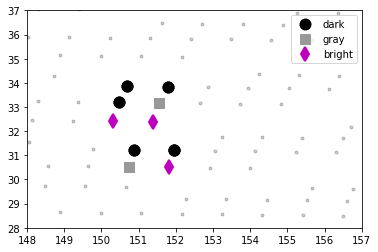

In [72]:
plot(alltiles['RA'], alltiles['DEC'], 'k.', alpha=0.2, label='_none_')
plot(explist['ra'][isdark], explist['dec'][isdark], 'o', color='k', ms=10, mew=2, label='dark')
plot(explist['ra'][isgray], explist['dec'][isgray], 's', color='0.6', ms=10, label='gray')
plot(explist['ra'][isbright], explist['dec'][isbright], 'd', color='m', ms=10, mew=2, label='bright')
legend(loc='upper right')
xlim(148, 157); ylim(28, 37)

In [73]:
nside = 64
pixels = desimodel.footprint.tiles2pix(nside, tiles)
nexp = np.count_nonzero(np.in1d(explist['tileid'], tiles['TILEID']))
print('{} tiles covered by {} exposures and {} healpixels'.format(len(tiles), nexp, len(pixels)))

10 tiles covered by 18 exposures and 47 healpixels


In [74]:
pixels

array([5261, 5262, 5263, 5272, 5273, 5274, 5275, 5278, 5281, 5283, 5284,
       5285, 5286, 5287, 5289, 5292, 5293, 5294, 5295, 5296, 5297, 5298,
       5299, 5300, 5301, 5302, 5303, 5304, 5305, 5306, 5307, 5308, 5309,
       5310, 5311, 5346, 5352, 5354, 5636, 5637, 5648, 5649, 5650, 5651,
       5652, 5653, 5654])

(28, 37)

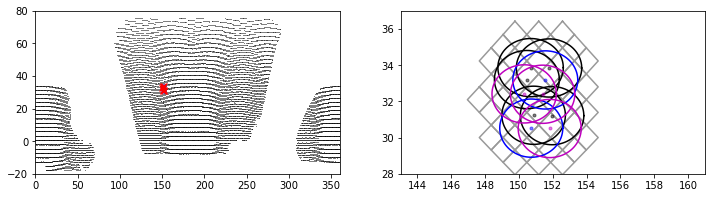

In [75]:
def plot_tile(ra, dec, r=1.606, color='k'):
    '''Approximate plot of tile location'''
    ang = np.linspace(0, 2*np.pi, 100)
    x = ra + r*np.cos(ang)/np.cos(np.radians(dec))
    y = dec + r*np.sin(ang)
    plot(x,y, '-', color=color)

def plot_healpix(nside, pixels):
    '''Plot healpix boundaries; doesn't work at RA wraparound'''
    for p in pixels:
        xyz = hp.boundaries(nside, p, nest=True)
        theta, phi = hp.vec2ang(xyz.T)
        theta = np.concatenate([theta, theta[0:1]])
        phi = np.concatenate([phi, phi[0:1]])
        ra, dec = np.degrees(phi), 90-np.degrees(theta)
        plot(ra, dec, '-', color='0.6')

figure(figsize=(12,3))
subplot(121)
plot(alltiles['RA'], alltiles['DEC'], 'k,', alpha=0.5)
plot(explist['ra'], explist['dec'], 'b.', alpha=0.5)
plot(tiles['RA'], tiles['DEC'], 'rx')
xlim(0,360); ylim(-20, 80)

subplot(122)
plot_healpix(nside, pixels)
color = dict(DARK='k', GRAY='b', BRIGHT='m')
for program in ['DARK', 'GRAY', 'BRIGHT']:
    ii = tiles['PROGRAM'] == program
    plot(tiles['RA'][ii], tiles['DEC'][ii], '.', color=color[program], alpha=0.5)
    jj = tiles['PROGRAM'] == program
    for t in tiles[jj]:
        plot_tile(t['RA'], t['DEC'], color=color[program])

xlim(143, 161); ylim(28, 37)

## Run select_mock_targets

This step combines mock catalogs with spectral templates per covered healpixel.
This notebook prints the commands to run in a separate cori login terminal to
get a 15 node interactive job, and then run the `mpi_select_mock_targets` command.
It should take ~15 minutes on 15 nodes.

In [80]:
cmd = "srun -A desi -N 15 -n 30 -c 16 " # -p debug -C haswell -t 00:30:00"
cmd += " mpi_select_mock_targets --output_dir {targetdir} --config ./select-mock-targets.yaml"
cmd += " --seed 1 --nproc 16 --nside 64 --tiles {tilefile}"
cmd = cmd.format(targetdir=targetdir, tilefile=tilefile)
print('# Start an interactive job.')
print()
print('salloc -A desi -N 15 -t 00:30:00 -C haswell --qos interactive')
print()
print('# After your interactive node starts up,')
print()
print(envcmd)
print('cd {}'.format(minitestdir))
print(cmd)

# Start an interactive job.

salloc -A desi -N 15 -t 00:30:00 -C haswell --qos interactive

# After your interactive node starts up,

source /project/projectdirs/desi/software/desi_environment.sh 17.9
basedir=${SCRATCH}/desi/dev/end2end
export DESISURVEY_OUTPUT=${basedir}/survey
export DESI_SPECTRO_REDUX=${basedir}/spectro/redux
export DESI_SPECTRO_SIM=${basedir}/spectro/sim
export SPECPROD=mini
export PIXPROD=mini
export DESI_SPECTRO_DATA=${DESI_SPECTRO_SIM}/${PIXPROD}

cd /global/cscratch1/sd/sjbailey/desi/code/two_percent_DESI/mini
srun -A desi -N 15 -n 30 -c 16  mpi_select_mock_targets --output_dir /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets --config ./select-mock-targets.yaml --seed 1 --nproc 16 --nside 64 --tiles /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/test-tiles.fits


## Check that we got the right number of target output files ##
The number of files of each type should match the number of healpixels

In [81]:
import glob
print("{} healpixels".format(len(pixels)))
for filetype in ['target', 'truth', 'sky', 'standards-dark', 'standards-bright']:
    filenames = glob.glob(os.path.join(targetdir, '*', '*', '{}*.fits'.format(filetype)))
    print('{} {} files'.format(len(filenames), filetype))

47 healpixels
47 target files
47 truth files
47 sky files
47 standards-dark files
47 standards-bright files


## Merge target, sky, and stdstar catalogs

mpi_select_mock_targets writes targets per healpixel.  This step combines them into full catalogs (but the truth spectra themselves are still kept in individual healpix-organized files, otherwise they would be too big).
It also generates the "Merged Target List" (mtl) that assigns priorities to targets for fiberassignment.
This step is fast so is spawned directly from the notebook without requiring a batch job.

In [82]:
# cmd = "srun -N 4 -n 8 -c 16 -p debug -C haswell -t 00:05:00"
cmd = "join_mock_targets --mockdir {} --force".format(targetdir)
print(cmd)
!$cmd

join_mock_targets --mockdir /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets --force
INFO:build.py:991:merge_file_tables: Writing /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/sky.fits
INFO:build.py:991:merge_file_tables: Writing /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/standards-dark.fits
INFO:build.py:991:merge_file_tables: Writing /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/standards-bright.fits
INFO:build.py:991:merge_file_tables: Writing /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/targets.fits
INFO:build.py:991:merge_file_tables: Writing /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/truth.fits
INFO:build.py:1068:join_targets_truth: Generating merged target list /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/mtl.fits
DEBUG: before targets.calc_priority slow copy
DEBUG: seconds for targets.calc_priority slow copy: 0.04877758026123047
DEBUG: calc_priority has 231354 unobserved targets
1 of 231354 targets have priorit

### Do some sanity checks on the results

In [83]:
targets = fitsio.read(os.path.join(targetdir, 'targets.fits'))
truth   = fitsio.read(os.path.join(targetdir, 'truth.fits'))
mtl     = fitsio.read(os.path.join(targetdir, 'mtl.fits'))
std     = fitsio.read(os.path.join(targetdir, 'standards-dark.fits'))
sky     = fitsio.read(os.path.join(targetdir, 'sky.fits'))

In [84]:
assert len(truth) == len(targets)                             #- same number of targets and truth
assert np.all(targets['TARGETID'] == truth['TARGETID'])       #- targets and truth are row matched
assert len(targets) == len(np.unique(targets['TARGETID']))    #- no repeated TARGETIDs
assert len(sky) == len(np.unique(sky['TARGETID']))            #- no repeated sky TARGETIDs
assert len(std) == len(np.unique(std['TARGETID']))            #- no repeated std TARGETIDs

assert np.all(np.in1d(targets['TARGETID'], mtl['TARGETID']))  #- all targets are in MTL

#- no sky targets should be in science targets, though it is possible for standards to also be MWS targets
assert not np.any(np.in1d(sky['TARGETID'], targets['TARGETID']))


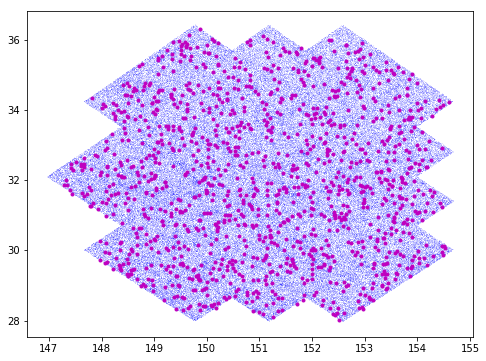

In [85]:
figure(figsize=(8,6))
plot(mtl['RA'], mtl['DEC'], 'b,', alpha=0.1)
plot(std['RA'], std['DEC'], 'm.')

## Run fiberassign

First, generate fiberassign configuration files pointing to the right inputs/outputs

In [86]:
#- Write list of tiles to consider
dx = open(os.path.join(fibassigndir, 'dark-tiles.txt'), 'w')
bx = open(os.path.join(fibassigndir, 'bright-tiles.txt'), 'w')
for tileid, program  in zip(tiles['TILEID'], tiles['PROGRAM']):
    if program == 'BRIGHT':
        bx.write(str(tileid)+'\n')
    else:
        dx.write(str(tileid)+'\n')

dx.close()
bx.close()

#- Generate config files for dark and bright
cmd = "config-fiberassign "
cmd += " --mtl {}/mtl.fits".format(targetdir)
cmd += " --stdstars {}/standards-dark.fits".format(targetdir)
cmd += " --sky {}/sky.fits".format(targetdir)
cmd += " --surveytiles {}/dark-tiles.txt".format(fibassigndir)
cmd += " --outdir {}".format(fibassigndir)
cmd += " --config {}/fiberassign-config-dark.txt".format(fibassigndir)
print(cmd)
!$cmd

cmd = "config-fiberassign "
cmd += " --mtl {}/mtl.fits".format(targetdir)
cmd += " --stdstars {}/standards-bright.fits".format(targetdir)
cmd += " --sky {}/sky.fits".format(targetdir)
cmd += " --surveytiles {}/bright-tiles.txt".format(fibassigndir)
cmd += " --outdir {}".format(fibassigndir)
cmd += " --config {}/fiberassign-config-bright.txt".format(fibassigndir)
print(cmd)
!$cmd

config-fiberassign  --mtl /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/mtl.fits --stdstars /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/standards-dark.fits --sky /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/sky.fits --surveytiles /global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/dark-tiles.txt --outdir /global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign --config /global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/fiberassign-config-dark.txt
config-fiberassign  --mtl /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/mtl.fits --stdstars /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/standards-bright.fits --sky /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/sky.fits --surveytiles /global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/bright-tiles.txt --outdir /global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign --config /global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/fiberassign-config-bright.tx

#### Now run fiberassign itself ####
runs in <20 seconds for this subset of tiles

In [87]:
!rm -f $fibassigndir/tile_*.fits
!fiberassign $fibassigndir/fiberassign-config-dark.txt > $fibassigndir/fa-dark.log
!fiberassign $fibassigndir/fiberassign-config-bright.txt > $fibassigndir/fa-bright.log
!echo $(ls $fibassigndir/tile*.fits | wc -l) tile files created


real	0m13.955s
user	0m2.769s
sys	0m3.110s

real	0m4.920s
user	0m2.459s
sys	0m2.411s
10 tile files created


#### Run fiberassign QA ####
This will find non-fatal errors with unassigned fibers and too few standards

In [88]:
!qa-fiberassign $fibassigndir/tile*.fits --targets $targetdir/targets.fits

/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_01165.fits - OK
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_06927.fits - ERROR
  1 unassigned fibers
  Petal 5 has 5/10 stdstars
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_11108.fits - OK
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_16870.fits - ERROR
  1 unassigned fibers
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_18465.fits - ERROR
  1 unassigned fibers
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_24227.fits - ERROR
  1 unassigned fibers
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_28408.fits - ERROR
  1 unassigned fibers
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_34170.fits - ERROR
  6 unassigned fibers
  Petal 1 has 9/10 stdstars
  Petal 5 has 8/10 stdstars
  Petal 6 has 9/10 stdstars
  Petal 8 has 6/10 stdstars
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_39942.

## Run newexp to combine surveysim, mocks, and fiberassign into simspec files

Setup the problem and define the commands to run, but then run them
in a separate window with desisim/newexp configured.

This step associates exposure IDs (EXPID) to observations and inserts 3 arcs and 3 flats
at the beginning of each night.

specsim is memory hungry so we are limited to one process per node, leaving
the other cores idle.

7.4 minutes for 21 arc, 21 flat, 36 science exposures on 15 nodes.

In [92]:
# cmd = "srun -N 4 -n 4 -c 32 -C haswell -p debug -t 00:30:00 --qos premium "
nodes = 15

print('# Start an interactive job.')
print()
print('salloc -A desi -N {nodes} -C haswell -t 1:00:00 --qos interactive'.format(nodes=nodes))
print()
print('# After your interactive node starts up, set the environment ...')
print()
print(envcmd)
print("# Then run this in the interactive node:")
print()
cmd = "srun -A desi -N {nodes} -n {nodes} -c 32".format(nodes=nodes)
cmd += " wrap-newexp --mpi --fiberassign {}".format(fibassigndir)
cmd += " --mockdir {}".format(targetdir)
cmd += " --obslist {}/exposures.fits".format(surveydir)
cmd += " --tilefile {}".format(tilefile)
print(cmd)

# Start an interactive job.

salloc -A desi -N 15 -C haswell -t 1:00:00 --qos interactive

# After your interactive node starts up, set the environment ...

source /project/projectdirs/desi/software/desi_environment.sh 17.9
basedir=${SCRATCH}/desi/dev/end2end
export DESISURVEY_OUTPUT=${basedir}/survey
export DESI_SPECTRO_REDUX=${basedir}/spectro/redux
export DESI_SPECTRO_SIM=${basedir}/spectro/sim
export SPECPROD=mini
export PIXPROD=mini
export DESI_SPECTRO_DATA=${DESI_SPECTRO_SIM}/${PIXPROD}

# Then run this in the interactive node:

srun -A desi -N 15 -n 15 -c 32 wrap-newexp --mpi --fiberassign /global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign --mockdir /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets --obslist /global/cscratch1/sd/sjbailey/desi/dev/end2end/survey/exposures.fits --tilefile /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/test-tiles.fits


### Confirm that we got the expected newexp output files

Unfortunately, in 17.9 it is wrap-newexp itself that assigned the exposure IDs and the only real way to know what it did was to see what it output, so the check here is more basic, just that we did get some output files for each night in the exposures list.

In [103]:
#- Note: for 17.9 these are lowercase with night YEAR-MM-DD;
#- for current master they are UPPERCASE with NIGHT YEARMMDD (no hyphens)
for night in explist['night']:
    night = night.decode().replace('-', '')
    simspecfiles = glob.glob(os.path.join(simdatadir, night, 'simspec*.fits'))
    fibermapfiles = glob.glob(os.path.join(simdatadir, night, 'fibermap*.fits'))
    if len(simspecfiles) == 0:
        print(os.path.join(simdatadir, night, 'simspec*.fits'))
        print('ERROR: missing simspec files for {}'.format(night))
    if len(simspecfiles) != len(fibermapfiles):
        print('ERROR: night {} number of simspec ({}) != number of fibermap ({})'.format(
                night, len(simspecfiles), len(fibermapfiles)))

## Run fastframe to generate noisy uncalibrated spectra

fastframe is a stripped down version of quickgen, and it uses specsim under the hood.
specsim is memory hungry so we are limited to one process per node, leaving
the other cores idle.

6.3 minutes for 12 arc, 12 flat, 18 science exposures on 15 nodes

In [90]:
cmd = "srun -A desi -N {nodes} -n {nodes} -c 32 wrap-fastframe --mpi".format(nodes=nodes)
print('#- From the same interactive job where you ran wrap-newexp, run this:')
print(cmd)

#- From the same interactive job where you ran wrap-newexp, run this:
srun -A desi -N 15 -n 15 -c 32 wrap-fastframe --mpi


In [137]:
#- also check the outputs from fastframe
import desispec.io
ntot = 0
nbad = 0
for night in set(explist['night']):
    night = night.decode().replace('-', '')
    fibermapfiles = glob.glob(os.path.join(simdatadir, night, 'fibermap*.fits'))
    for fmfile in fibermapfiles:
        hdr = fits.getheader(fmfile, 1)
        if hdr['FLAVOR'] in ('science', 'flat'):
            expid = hdr['EXPID']
            for channel in ['b', 'r', 'z']:
                for spectrograph in range(10):
                    camera = channel + str(spectrograph)
                    framefile = desispec.io.findfile('frame', night, expid, camera)
                    ntot += 1
                    if not os.path.exists(framefile):
                        nbad += 1
                        print('Missing', framefile)

if nbad > 0:
    print('Missing {}/{} frame files'.format(nbad, ntot))
else:
    print('All {} science and flat frame files generated'.format(ntot))

All 900 science and flat frame files generated


## Run the spectro pipeline

  * generate the production scripts
  * launch them

The pipeline massively overestimates the time to run each step, so at submission time dial the time back to just 10 minutes.

In [119]:
#- Equivalent to running `desi_pipe` from the command line
from desispec.scripts import pipe_prod
args = pipe_prod.parse('--nersc_host cori --nersc_queue debug --fakepix'.split())
pipe_prod.main(args)

Working with production /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini :
  Updating plans ...
  Creating setup.sh ...
  Selecting nights ...
  Finding max processes supported by workers ...
    bootstrap : 1 processes per task
    psf : 20 processes per task
    psfcombine : 1 processes per task
    extract : 20 processes per task
    fiberflat : 1 processes per task
    sky : 1 processes per task
    stdstars : 1 processes per task
    fluxcal : 1 processes per task
    calibrate : 1 processes per task
    redshift : 16 processes per task
  Generating scripts ...
113 nodes too big for debug queue; switching to regular
113 nodes too big for debug queue; switching to regular
113 nodes too big for debug queue; switching to regular
113 nodes too big for debug queue; switching to regular
65 minutes too big for debug queue; switching to regular
65 minutes too big for debug queue; switching to regular
65 minutes too big for debug queue; switching to regular
65 minutes too 

In [120]:
#- Find nights that observed these tiles
nights = unique(np.char.replace(np.char.decode(explist['night']), '-', ''))
print(nights)

['20200315' '20200316' '20200318' '20200319']


In [121]:
for night in nights:
    launchcmd = 'sbatch -A desi --time 00:10:00 -p debug {reduxdir}/run/scripts/{night}/fiberflat-calibrate_{night}.slurm'.format(
        reduxdir=reduxdir, night=night
    )
    print(launchcmd)
    err = subprocess.call(launchcmd.split())
    if err != 0:
        print('ERROR {} while launching {}'.format(err, night))

sbatch -A desi --time 00:10:00 -p debug /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/run/scripts/20200315/fiberflat-calibrate_20200315.slurm
sbatch -A desi --time 00:10:00 -p debug /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/run/scripts/20200316/fiberflat-calibrate_20200316.slurm
sbatch -A desi --time 00:10:00 -p debug /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/run/scripts/20200318/fiberflat-calibrate_20200318.slurm
sbatch -A desi --time 00:10:00 -p debug /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/run/scripts/20200319/fiberflat-calibrate_20200319.slurm


### Monitor those jobs until they have all completed

Due to debug queue limits, only 2 will run at a time, but they should take <10 minutes each

In [153]:
qq = 'squeue -u {USER}'.format(**os.environ)
print(qq)
!$qq

squeue -u sjbailey
             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)


### Check that we got expected outputs
This includes both calibration and science exposures

In [154]:
ii = np.in1d(explist['tileid'], tiles['TILEID'])
nsci = len(explist[ii])
nflat = 3*len(nights)
nframe = 30*(nsci+nflat)
ncframe = 30*nsci
framefiles = sorted(glob.glob('{}/exposures/*/*/frame*.fits'.format(reduxdir)))
cframefiles = sorted(glob.glob('{}/exposures/*/*/cframe*.fits'.format(reduxdir)))
print('frame {}/{}, cframe {}/{}'.format(len(framefiles), nframe, len(cframefiles), ncframe))

if len(framefiles) != nframe:
    print('ERROR: missing frame files')
if len(cframefiles) != ncframe:
    print('ERROR: missing cframe files')

frame 900/900, cframe 540/540


## Regroup spectra from frames -> healpix

The data so far are grouped on disk by exposure in calibrated frame files.
Regroup into sets of spectra in the same healpix on the sky.

This script is asking for 1 node for 2 hours (!).  Try running as interactive job on 6 nodes with 8 workers per node.  ~20 minutes.

In [156]:
#- Equivalent to running `desi_group_spectra --hpxnside 64` from command line (this is slow)
# from desispec.scripts import group_spectra
# args = group_spectra.parse('--hpxnside 64'.split())
# group_spectra.main(args)

#- To run as a batch job instead (including MPI parallelism)

print('# Start an interactive job.\n')
print('salloc -A desi -N 6 -t 1:00:00 -C haswell --qos interactive')
print()
print('# Set the environment.\n')
if 'csh' in os.environ['SHELL']:
    print('setenv TMPDIR /dev/shm')
else:
    print('export TMPDIR=/dev/shm')
print(envcmd)

print('# Group cframe -> spectra.\n')

print('srun --cpu_bind=cores -N 6 -n 48 -c 8 desi_group_spectra --pipeline')
# cmd = 'sbatch {}/run/scripts/spectra.slurm'.format(reduxdir)
# print(cmd)
# !$cmd

# Start an interactive job.

salloc -A desi -N 6 -t 1:00:00 -C haswell --qos interactive

# Set the environment.

export TMPDIR=/dev/shm
source /project/projectdirs/desi/software/desi_environment.sh 17.9
basedir=${SCRATCH}/desi/dev/end2end
export DESISURVEY_OUTPUT=${basedir}/survey
export DESI_SPECTRO_REDUX=${basedir}/spectro/redux
export DESI_SPECTRO_SIM=${basedir}/spectro/sim
export SPECPROD=mini
export PIXPROD=mini
export DESI_SPECTRO_DATA=${DESI_SPECTRO_SIM}/${PIXPROD}

# Group cframe -> spectra.

srun --cpu_bind=cores -N 6 -n 48 -c 8 desi_group_spectra --pipeline


## Did all pixels make it from sims -> output spectra?

It looks like tiles2pix was conservative and included some edge pixels that weren't
really necessary.

Missing spectra-64-5636.fits


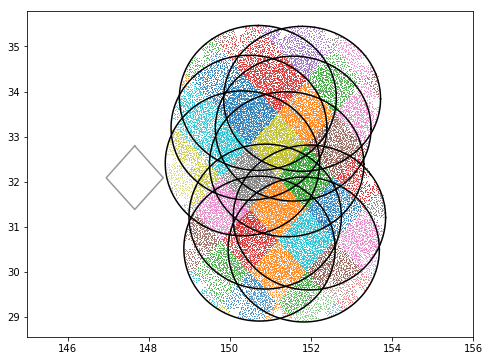

In [207]:
import desispec.io
nside=64
misspix = list()
figure(figsize=(8,6))
for p in pixels:
    specfile = desispec.io.findfile('spectra', nside=nside, groupname=str(p))
    if not os.path.exists(specfile):
        print('Missing {}'.format(os.path.basename(specfile)))
        misspix.append(p)
    else:
        fibermap = Table.read(specfile, 'FIBERMAP')
        plot(fibermap['RA_TARGET'], fibermap['DEC_TARGET'], ',', alpha=0.5)

plot_healpix(nside, misspix)
for t in tiles:
    plot_tile(t['RA'], t['DEC'])

tmp = xlim(145, 156)

## Run redrock redshift fitting

desispec/0.16.0 has a bug in how spectra are distributed over MPI ranks for the pipeline wrapper of redrock.
Bypass this by using the `two_percent_DESI/mini/wrap-redrock` script.  Takes ~30 min.

In [196]:
nodes = 15
print('''
# Start an interactive job.

salloc -A desi -N {nodes} -t 2:00:00 -C haswell --qos interactive

# Set the environment.

{envcmd}
# run redrock.

time srun -A desi -N {nodes} -n {nodes} -c 64 {minitestdir}/wrap-redrock --mpi --ncpu 32
'''.format(envcmd=envcmd, minitestdir=minitestdir, nodes=nodes))


# Start an interactive job.

salloc -A desi -N 15 -t 2:00:00 -C haswell --qos interactive

# Set the environment.

source /project/projectdirs/desi/software/desi_environment.sh 17.9
basedir=${SCRATCH}/desi/dev/end2end
export DESISURVEY_OUTPUT=${basedir}/survey
export DESI_SPECTRO_REDUX=${basedir}/spectro/redux
export DESI_SPECTRO_SIM=${basedir}/spectro/sim
export SPECPROD=mini
export PIXPROD=mini
export DESI_SPECTRO_DATA=${DESI_SPECTRO_SIM}/${PIXPROD}

# run redrock.

time srun -A desi -N 15 -n 15 -c 64 /global/cscratch1/sd/sjbailey/desi/code/two_percent_DESI/mini/wrap-redrock --mpi --ncpu 32



### Check redrock output

In [197]:
import desitarget.io
zbestfiles = list(desitarget.io.iter_files(reduxdir, 'zbest'))
specfiles = list(desitarget.io.iter_files(reduxdir, 'spectra'))
print('{}/{} zbest files created'.format(len(zbestfiles), len(specfiles)))
for spfile in specfiles:
    zbfile = spfile.replace('spectra-64-', 'zbest-64-')
    if zbfile not in zbestfiles:
        print('MISSING {}'.format(zbfile))

46/46 zbest files created


### Count number of spectra and targets per healpix

In [198]:
import desispec.io

specdir = os.path.join(os.environ['DESI_SPECTRO_REDUX'], os.environ['SPECPROD'], 'spectra-64')
specfiles = list()
print('==================== ===== ========')
print('specfile             nspec ntargets')
print('==================== ===== ========')
for specfile in sorted(list(desitarget.io.iter_files(specdir, 'spectra'))):
    fm = desispec.io.read_fibermap(specfile)
    ntarg = len(np.unique(fm['TARGETID']))
    nspec = len(fm) * 3
    specfiles.append( (ntarg, nspec, os.path.basename(specfile)) )
    print("{0:20s} {1:5d} {2:8d}".format(os.path.basename(specfile), nspec, ntarg))
print('==================== ===== ========')

==================== ===== ========
specfile             nspec ntargets
==================== ===== ========
spectra-64-5261.fits   138       46
spectra-64-5262.fits   435       94
spectra-64-5263.fits  4047      865
spectra-64-5272.fits   534      178
spectra-64-5273.fits   171       57
spectra-64-5274.fits  6951     1148
spectra-64-5275.fits  5751      949
spectra-64-5278.fits  1227      137
spectra-64-5281.fits   126       21
spectra-64-5283.fits   474       79
spectra-64-5284.fits  3858      737
spectra-64-5285.fits 10899     1677
spectra-64-5286.fits  5235      907
spectra-64-5287.fits 11436     1895
spectra-64-5289.fits    36        6
spectra-64-5292.fits  3609      595
spectra-64-5293.fits  9237     1773
spectra-64-5294.fits   120       39
spectra-64-5295.fits  3987      913
spectra-64-5296.fits 12474     1886
spectra-64-5297.fits 10137     1713
spectra-64-5298.fits 16167     2844
spectra-64-5299.fits 17361     2740
spectra-64-5300.fits  4704      725
spectra-64-5301.fits    60  

## Create zcatalog

In [199]:
cmd = 'desi_zcatalog -i {reduxdir}/spectra-64 -o {reduxdir}/zcatalog.fits'.format(reduxdir=reduxdir)
print(cmd)
!$cmd

desi_zcatalog -i /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/spectra-64 -o /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/zcatalog.fits


## Redshift QA

In [200]:
truth = Table.read(os.path.join(targetdir, 'truth.fits'))
zcat = Table.read(os.path.join(reduxdir, 'zcatalog.fits'))

truth['TRUESPECTYPE'] = np.char.strip(truth['TRUESPECTYPE'])
truth['TEMPLATETYPE'] = np.char.strip(truth['TEMPLATETYPE'])
zcat['SPECTYPE'] = np.char.strip(zcat['SPECTYPE'])

In [201]:
import astropy.table
del zcat.meta['EXTNAME']
del truth.meta['EXTNAME']
ztruth = astropy.table.join(zcat, truth, keys='TARGETID')

In [202]:
isELG = (ztruth['TEMPLATETYPE'] == 'ELG')
isQSO = (ztruth['TEMPLATETYPE'] == 'QSO')
isLRG = (ztruth['TEMPLATETYPE'] == 'LRG')
isSTAR = (ztruth['TEMPLATETYPE'] == 'STAR')
isBGS = (ztruth['TEMPLATETYPE'] == 'BGS')
print('QSO ', np.count_nonzero(isQSO))
print('LRG ', np.count_nonzero(isLRG))
print('ELG ', np.count_nonzero(isELG))
print('STAR', np.count_nonzero(isSTAR))
print('BGS ', np.count_nonzero(isBGS))

QSO  3106
LRG  5213
ELG  17954
STAR 2065
BGS  12467


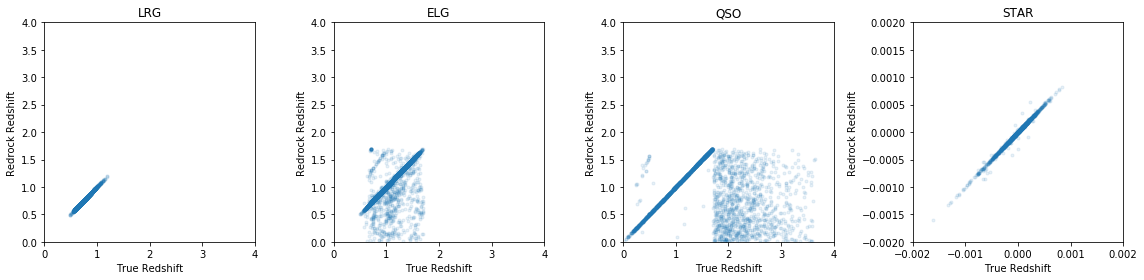

In [203]:
def plotz(ztruth, label, zmin=0.0, zmax=1.5, ylabel_=None):
    plot(ztruth['TRUEZ'], ztruth['Z'], '.', label=label, alpha=0.1)
    title(label)
    xlim(zmin, zmax); ylim(zmin, zmax)
    xlabel('True Redshift')
    ylabel('Redrock Redshift')

figure(figsize=(16,4))
subplot(141); plotz(ztruth[isLRG], 'LRG', zmax=4)
subplot(142); plotz(ztruth[isELG], 'ELG', zmax=4)
subplot(143); plotz(ztruth[isQSO], 'QSO', zmax=4)
subplot(144); plotz(ztruth[isSTAR], 'STAR', zmin=-0.002, zmax=0.002)
tight_layout()

In [204]:
def zstats(zx, dvlimit=1000, count=False):
    dv = 1e5 * (zx['Z'] - zx['TRUEZ'])/(1+zx['TRUEZ'])
    good = (np.abs(dv)<=dvlimit) & (zx['ZWARN'] == 0)
    fail = (np.abs(dv)> dvlimit) & (zx['ZWARN'] == 0)
    miss = (np.abs(dv)<=dvlimit) & (zx['ZWARN'] != 0)
    lost = (np.abs(dv)> dvlimit) & (zx['ZWARN'] != 0)
    ngood = np.count_nonzero(good)
    nfail = np.count_nonzero(fail)
    nmiss = np.count_nonzero(miss)
    nlost = np.count_nonzero(lost)
    ntot = len(dv)
    assert(ntot == ngood+nfail+nmiss+nlost)
    if count:
        return ngood, nfail, nmiss, nlost
    elif ntot == 0:
        return (np.nan, np.nan, np.nan, np.nan)
    else:
        return 100*ngood/ntot, 100*nfail/ntot, 100*nmiss/ntot, 100*nlost/ntot

print('          ntarg   good  fail  miss  lost')
for objtype in set(ztruth['TEMPLATETYPE']):
    isx = (ztruth['TEMPLATETYPE'] == objtype)
    pgood, pfail, pmiss, plost = zstats(ztruth[isx])
    nx = np.count_nonzero(isx)
    print('{:6s} {:8d}  {:5.1f} {:5.1f} {:5.1f} {:5.1f}'.format(objtype, nx, pgood, pfail, pmiss, plost))

print()
print('good = correct redshift and ZWARN==0')
print('fail = bad redshift and ZWARN==0 (i.e. catastrophic failures)')
print('miss = correct redshift ZWARN!=0 (missed opportunities)')
print('lost = wrong redshift ZWARN!=0 (wrong but at least we know it)')

          ntarg   good  fail  miss  lost
WD           80   86.2  10.0   0.0   3.8
STAR       2065   81.6   0.6   2.7  15.1
QSO        3106   60.8   2.2   1.0  36.0
BGS       12467   99.6   0.0   0.3   0.1
LRG        5213  100.0   0.0   0.0   0.0
ELG       17954   91.2   0.4   4.4   4.1

good = correct redshift and ZWARN==0
fail = bad redshift and ZWARN==0 (i.e. catastrophic failures)
miss = correct redshift ZWARN!=0 (missed opportunities)
lost = wrong redshift ZWARN!=0 (wrong but at least we know it)


## What happened to the high-z QSOs?

This is a bug in the QSO template generation in desispec 16.0 included in the desimodules 17.9 release.

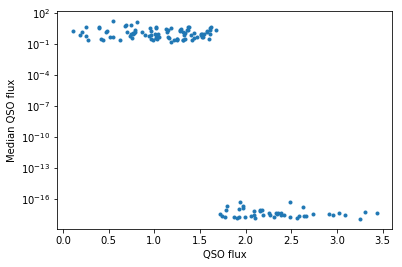

In [205]:
from astropy.io import fits
targetfile = os.path.join(targetdir, '53', '5300', 'truth-64-5300.fits')
xflux = fits.getdata(targetfile, 'FLUX')
xtrue = Table.read(targetfile, 'TRUTH')
isqso = xtrue['TRUESPECTYPE'] == 'QSO'
xflux = xflux[isqso]
xtrue = xtrue[isqso]
tmpflux = np.median(xflux, axis=1)

plot(xtrue['TRUEZ'], tmpflux, '.')
semilogy()
xlabel('QSO flux'); ylabel('Median QSO flux')

## Study QSO efficiency vs. FLUX_G

The failures are dominated by z>1.7 input spectra with the wrong flux units, but the lowz QSOs
are so efficient that is isn't very meaningful to bin them.  Leaving this code in here for now in case it is useful in a later update.

In [172]:
g = ztruth['FLUX_G']
magbins = np.linspace(16, 24, 17)
midmag = 0.5*(magbins[0:-1] + magbins[1:])
zeff = list()
for i in range(len(magbins)-1):
    maglo, maghi = magbins[i:i+2]
    ismag = (maglo < g) & (g < maghi)
    pgood, pfail, pmiss, plost = zstats(ztruth[isQSO & ismag])
    nmag = np.count_nonzero(isQSO & ismag)
    print('{:.1f}-{:.1f} {:4d} {:6s} {:5.1f} {:5.1f} {:5.1f} {:5.1f}'.format(maglo, maghi, nmag, 'QSO', pgood, pfail, pmiss, plost))
    zeff.append(pgood)


16.0-16.5   10 QSO     80.0   0.0   0.0  20.0
16.5-17.0   12 QSO     66.7   0.0   8.3  25.0
17.0-17.5    4 QSO    100.0   0.0   0.0   0.0
17.5-18.0   12 QSO     83.3   0.0   0.0  16.7
18.0-18.5    5 QSO    100.0   0.0   0.0   0.0
18.5-19.0    9 QSO     88.9   0.0   0.0  11.1
19.0-19.5    5 QSO    100.0   0.0   0.0   0.0
19.5-20.0   10 QSO     70.0   0.0   0.0  30.0
20.0-20.5    1 QSO    100.0   0.0   0.0   0.0
20.5-21.0    4 QSO    100.0   0.0   0.0   0.0
21.0-21.5    9 QSO     88.9  11.1   0.0   0.0
21.5-22.0    8 QSO     87.5   0.0   0.0  12.5
22.0-22.5    2 QSO     50.0   0.0   0.0  50.0
22.5-23.0   10 QSO     90.0   0.0   0.0  10.0
23.0-23.5    5 QSO    100.0   0.0   0.0   0.0
23.5-24.0    4 QSO     50.0   0.0   0.0  50.0


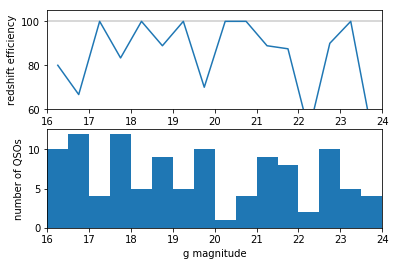

In [173]:
subplot(211)
axhline(100, color='0.8')
plot(midmag, zeff)
xlim(magbins[0], magbins[-1])
ylabel('redshift efficiency')
ylim(60,105)

subplot(212)
hist(g[isQSO], len(magbins)-1, (magbins[0], magbins[-1]))
xlim(magbins[0], magbins[-1])
xlabel('g magnitude')
ylabel('number of QSOs')

# TODO

A wishlist of things to add to this notebook (but not necessarily blocking factors for merging)
* Target selection QA
* spectro pipeline QA
* other QA?